a) Extraer atributos a partir de los audios correspondientes a los digitos del 0 al 9. Utilizar el [material suplementario](https://colab.research.google.com/drive/1Yv2SaE529gNIcKd68nAd8LzhFip6vm12?usp=sharing) dado durante la clase de presentación del TP.
- [Colab de extracción del dataset](https://colab.research.google.com/drive/1-2VwDfO-7sYHUrJdnL-oFS9LMEmroXT2)

In [ ]:

import pandas as pd
import numpy as np
random_state = 1


In [ ]:
url = 'https://raw.githubusercontent.com/NickCis/maestria-dm-datasets/master/tp-2/dataset.csv'
dataset = pd.read_csv(url, index_col = 0)
print(dataset.shape)
dataset.head()

(23666, 81)


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,dmfcc_0_mean,dmfcc_1_mean,dmfcc_2_mean,dmfcc_3_mean,dmfcc_4_mean,dmfcc_5_mean,dmfcc_6_mean,dmfcc_7_mean,dmfcc_8_mean,dmfcc_9_mean,dmfcc_10_mean,dmfcc_11_mean,denergy_mean,ddmfcc_0_mean,ddmfcc_1_mean,ddmfcc_2_mean,ddmfcc_3_mean,ddmfcc_4_mean,ddmfcc_5_mean,ddmfcc_6_mean,ddmfcc_7_mean,ddmfcc_8_mean,ddmfcc_9_mean,ddmfcc_10_mean,ddmfcc_11_mean,ddenergy_mean,mfcc_0_std,...,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,dmfcc_0_std,dmfcc_1_std,dmfcc_2_std,dmfcc_3_std,dmfcc_4_std,dmfcc_5_std,dmfcc_6_std,dmfcc_7_std,dmfcc_8_std,dmfcc_9_std,dmfcc_10_std,dmfcc_11_std,denergy_std,ddmfcc_0_std,ddmfcc_1_std,ddmfcc_2_std,ddmfcc_3_std,ddmfcc_4_std,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,target,filename,type
0,-412.950393,117.244823,-0.734987,1.778847,-7.701191,5.410619,-40.875472,-19.345404,-19.186588,-18.766388,-2.892563,-4.001418,0.029595,112.389783,58.885291,50.652881,30.015593,21.477807,14.495284,20.922666,17.576725,18.932362,18.676792,13.282394,7.400572,0.031669,0.211805,0.256189,0.161126,-0.117074,0.025678,0.008596,-0.429080,-0.178320,0.050076,-0.102248,-0.037344,-0.143862,0.000006,30.499361,...,26.668030,19.136425,13.233145,8.446257,9.373162,9.671860,12.354911,8.572466,8.079900,7.001229,0.008955,-0.204021,-0.121106,0.278634,0.516892,0.247983,-0.095782,0.045135,0.069232,-0.043389,0.175689,0.168375,0.028578,-0.000001,23.274924,22.383245,22.829785,17.520999,13.277633,8.648802,10.711590,9.889390,12.909328,7.461566,8.267924,9.267157,0.005515,zero,/content/speechcommands/zero/de650823_nohash_0...,training
1,-184.623268,96.833806,2.487826,34.155175,10.467560,9.131182,-18.418053,7.247336,-7.124059,-2.003087,-1.518222,10.745380,0.148276,128.589011,55.315778,39.469110,24.225266,15.883483,16.421223,23.255890,14.050639,10.605741,10.436307,14.082269,7.669333,0.130825,0.806799,0.519813,0.164510,-0.092114,-0.322688,-0.437343,-0.209258,-0.226610,-0.351908,-0.163975,0.061610,0.406814,-0.000079,35.337486,...,13.959099,13.266291,7.104921,7.505739,9.365928,7.335562,7.187849,6.935698,6.250266,4.875026,0.032167,-0.781415,-0.543196,0.073224,0.448566,0.321550,0.200049,-0.019091,0.042823,0.265781,-0.240417,-0.107719,-0.083960,-0.000209,26.705974,25.014755,10.933910,11.450284,7.201255,8.881178,10.792147,8.060065,9.097018,8.663988,5.617873,6.077835,0.020124,zero,/content/speechcommands/zero/fcb25a78_nohash_0...,training
2,-299.395174,66.321383,6.211742,14.826685,-17.382421,12.918089,-16.809546,-3.603513,-1.897363,-13.333361,-7.976516,-15.919249,0.063318,174.086149,56.348292,51.043419,37.549092,19.949080,20.799713,28.837724,13.764624,12.318299,13.533997,15.806820,16.660790,0.070733,1.825193,1.158724,-0.206831,-1.943246,-1.423475,1.833715,0.818940,-0.532702,-0.882885,-0.633452,0.860438,-0.587231,0.000056,42.767023,...,16.468948,10.520781,8.552100,7.765831,11.117452,8.198567,9.269083,7.903301,9.853061,8.166954,0.020358,0.210641,-0.241863,-0.292882,0.192271,-0.061972,-0.224645,-0.338050,-0.303883,0.085734,-0.009883,-0.054359,0.278057,-0.000006,24.201976,24.816234,14.458875,9.561773,11.735594,8.452892,11.072246,11.320777,10.190095,9.443072,9.711596,8.684745,0.012553,zero,/content/speechcommands/zero/94de6a6a_nohash_0...,testing
3,-346.608838,108.448435,43.367491,28.354521,11.546525,-4.193213,-4.270370,-2.414528,-3.629054,-7.512036,-6.301531,-6.713196,0.066435,155.621859,45.650955,31.931691,22.891892,17.048652,14.696233,23.180492,18.853988,14.079544,11.289771,9.279852,9.705594,0.072532,0.796964,0.719777,0.107631,-0.099534,-0.148393,-0.062998,0.344759,0.655713,0.590770,0.487649,0.422049,0.270204,0.000017,49.507864,...,19.128330,15.852077,10.885547,11.480641,13.355514,11.378897,6.701951,7.255883,6.244587,8.825742,0.019964,-0.338694,-0.349976,-0.168947,-0.172503,-0.258507,-0.

In [ ]:
target = 'target'
features = list(filter(lambda x: not (x in [target, 'filename', 'type']), dataset.columns))

b) Utilizar la división de datos provista en el dataset para entrenamiento, validación y evaluación de los modelos a desarrollar.

training (18620, 81)
testing (2552, 81)
validation (2494, 81)


one      1892
seven    1875
nine     1875
two      1873
zero     1866
six      1863
eight    1852
five     1844
three    1841
four     1839
Name: target, dtype: int64

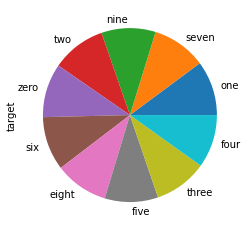

In [ ]:
training = dataset[dataset['type'] == 'training']
testing = dataset[dataset['type'] == 'testing']
validation = dataset[dataset['type'] == 'validation']

print("training", training.shape)
print("testing", testing.shape)
print("validation", validation.shape)
training[target].value_counts().plot.pie()
training[target].value_counts()

**REDES NEURONALES**

**Implementación Tensorflow**



In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow.keras.layers as tfkl
import tensorflow as tf


param_distributions = {
    'n_estimators': range(20, 200, 5),
    'max_depth': range(1, 7),
    'learning_rate': np.arange(0, 1, 0.001)
}


train_labels=training["target"].values
test_labels=testing["target"].values
val_labels=validation["target"].values
ohe = OneHotEncoder()
train_labels = ohe.fit_transform(train_labels.reshape(-1,1)).toarray()
test_labels = ohe.fit_transform(test_labels.reshape(-1,1)).toarray()
val_labels = ohe.fit_transform(val_labels.reshape(-1,1)).toarray()


layer_in = tfkl.Input(shape=(78)) #Todo modelo necesita una entrada, y debemos especificar sus dimensiones


flatten_layer = tfkl.Flatten()(layer_in)
#Esta es la capa oculta
hidden_layer = tfkl.Dense(units=1, activation='relu')(flatten_layer)
#Esta es la capa de salida:
output_layer = tfkl.Dense(units=10,activation='softmax')(hidden_layer)  

mlp_model = tf.keras.Model(inputs=[layer_in],outputs=[output_layer])

tf.keras.utils.plot_model(mlp_model,show_shapes=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics_list = [tf.keras.metrics.CategoricalAccuracy(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()]


        

mlp_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=metrics_list)



Se define la función que entrenará el modelo




In [ ]:
def entrenar_modelo(hparams):
  layer_in = tfkl.Input(shape=(78)) 

  flatten_layer = tfkl.Flatten()(layer_in)
  #Esta es la capa de salida
  hidden_layer = tfkl.Dense(units=hparams['units'], activation=hparams['activation'])(flatten_layer)
  #Esta es la capa de salida:
  output_layer = tfkl.Dense(units=10,activation='softmax')(hidden_layer) 

  mlp_model = tf.keras.Model(inputs=[layer_in],outputs=[output_layer])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  metrics_list = [tf.keras.metrics.CategoricalAccuracy(),
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.AUC()]
  metric_names = ['loss','acc','precision','recall','auc']
  mlp_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=metrics_list)

  cb_list = [tf.keras.callbacks.TensorBoard(log_dir='tblogs'),
              tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints'),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]

  history = mlp_model.fit(x=training[features],y=train_labels,validation_data=(validation[features],val_labels),batch_size=128,epochs=50,callbacks=cb_list)
  print(history.history.keys())
  performance = mlp_model.evaluate(x=validation[features],y=val_labels)
  performance = dict(zip(metric_names,performance))

  return mlp_model, performance, hparams

Se entrena el modelo obteniendo el de mejor performance. Los hiperparámetros a buscar son la cantidad de neuronas de la capa oculta y su función de activación.




In [ ]:
best_recall = 0
best_model = None
best_params = None
hyp_results = []
from sklearn.model_selection import ParameterSampler

hyperparameter_space = {'units': np.arange(10,1000,20),'activation': ['relu','tanh','sigmoid','elu'],'batch_size':[16,32,64,128,256,512]}
hyperparameters = list(ParameterSampler(hyperparameter_space,n_iter=10))


for hparam in hyperparameters:
  model, perf, hparams = entrenar_modelo(hparam)
  if perf['acc'] > best_recall:
    best_recall = perf['acc']
    best_model = model
    best_params = hparams
  hyp_results.append({'params': hparams,'performance': perf})

Epoch 1/50
146/146 [==============================] - 2s 16ms/step - loss: 1.5708 - categorical_accuracy: 0.4903 - precision_15: 0.8769 - recall_15: 0.1534 - auc_15: 0.8604 - val_loss: 1.1683 - val_categorical_accuracy: 0.6255 - val_precision_15: 0.8510 - val_recall_15: 0.3665 - val_auc_15: 0.9276
Epoch 2/50
146/146 [==============================] - 2s 12ms/step - loss: 1.0354 - categorical_accuracy: 0.6653 - precision_15: 0.8415 - recall_15: 0.4682 - auc_15: 0.9417 - val_loss: 1.0070 - val_categorical_accuracy: 0.6688 - val_precision_15: 0.8131 - val_recall_15: 0.5217 - val_auc_15: 0.9424
Epoch 3/50
146/146 [==============================] - 2s 14ms/step - loss: 0.9212 - categorical_accuracy: 0.6941 - precision_15: 0.8273 - recall_15: 0.5607 - auc_15: 0.9522 - val_loss: 0.9333 - val_categorical_accuracy: 0.6977 - val_precision_15: 0.8151 - val_recall_15: 0.5850 - val_auc_15: 0.9493
Epoch 4/50
146/146 [==============================] - 2s 12ms/step - loss: 0.8540 - categorical_accurac

Visualizamos la arquitectura del mejor modelo

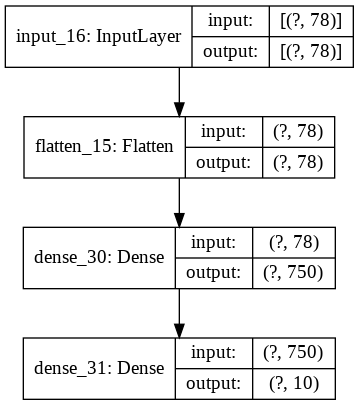

In [ ]:

tf.keras.utils.plot_model(best_model,show_shapes=True)

Creamos una función para realizar las predicciones debido a que se debe transformar la salida de la predicción a nuestras variables categóricas.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def predict_RN(neuralNetTenksor, test_ds=testing[features] ):
  ohe = OneHotEncoder()
 
  labels = np.array(['zero','one', 'two', 'three', 'four' ,'five' ,'six', 'seven' ,'eight' ,'nine'])
  ohe.fit_transform(labels.reshape(-1,1))
  y_predict_rn=neuralNetTenksor.predict(test_ds)
  y_predict_rn=ohe.inverse_transform(y_predict_rn)
  return y_predict_rn

Realizamos la predicción en el conjunto de testing y obtenemos las métricas con la matriz de confusión.

<Figure size 720x432 with 0 Axes>

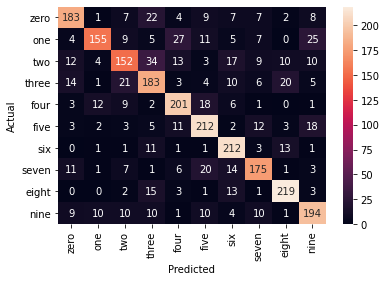

              precision    recall  f1-score   support

       eight       0.81      0.85      0.83       257
        five       0.73      0.78      0.76       271
        four       0.74      0.79      0.77       253
        nine       0.72      0.75      0.74       259
         one       0.83      0.62      0.71       248
       seven       0.76      0.73      0.74       239
         six       0.73      0.87      0.79       244
       three       0.64      0.69      0.66       267
         two       0.69      0.58      0.63       264
        zero       0.77      0.73      0.75       250

    accuracy                           0.74      2552
   macro avg       0.74      0.74      0.74      2552
weighted avg       0.74      0.74      0.74      2552



In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
numbers = ['zero','one', 'two', 'three', 'four' ,'five' ,'six', 'seven' ,'eight' ,'nine']

clf_rn_tensorflow_y_pred=predict_RN(best_model)
cm=confusion_matrix(testing[target], clf_rn_tensorflow_y_pred, labels=numbers)
cm = pd.DataFrame(cm, index=numbers, columns=numbers)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(10,6))  
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='', ax=ax)
#plt.savefig(filename)
plt.show()
print(classification_report(testing[target], clf_rn_tensorflow_y_pred))
